# Eigen Portfolios
I read a blog post recently in which the author utilized dimensionality reduction to create a tactical asset allocation strategy. I was curious about this technique so sought out to implement it myself.

# Load Packages

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from tiingo import TiingoClient

pd.core.common.is_list_like = pd.api.types.is_list_like
from sklearn.decomposition import PCA
import bt

# Standard plotly imports
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode, download_plotlyjs, plot

# Using plotly + cufflinks in offline mode
import cufflinks

cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)
config = {}
config["session"] = True
config["api_key"] = "9606b7b7c092fa68b5726d3feee8d44f40354fe3"
client = TiingoClient(config)

# Load Data

In [2]:
start_date = "2005-01-01"
end_date = "2019-01-31"
tickers = ["SPY", "EFA", "EEM", "IEF", "TLT", "GLD", "DBC", "VNQ", "HYG", "LQD"]

start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)
prices = pd.DataFrame()

for ticker in tickers:
    prices[ticker] = client.get_dataframe(
        ticker, startDate=start_date, endDate=end_date
    ).loc[:, "adjClose"]
print(prices.head())

                                 SPY        EFA        EEM        IEF  \
date                                                                    
2005-01-03 00:00:00+00:00  90.341626  35.796538  17.139783  56.662434   
2005-01-04 00:00:00+00:00  89.237701  35.110306  16.612075  56.309625   
2005-01-05 00:00:00+00:00  88.621906  35.087807  16.408715  56.402820   
2005-01-06 00:00:00+00:00  89.072488  35.087807  16.397560  56.456074   
2005-01-07 00:00:00+00:00  88.944823  34.930311  16.429308  56.409476   

                                 TLT    GLD  DBC        VNQ  HYG        LQD  
date                                                                         
2005-01-03 00:00:00+00:00  54.028742  43.02  NaN  29.437298  NaN  60.588323  
2005-01-04 00:00:00+00:00  53.462518  42.74  NaN  28.994870  NaN  60.248273  
2005-01-05 00:00:00+00:00  53.748674  42.67  NaN  28.031007  NaN  60.296852  
2005-01-06 00:00:00+00:00  53.785205  42.15  NaN  28.246955  NaN  60.340033  
2005-01-07 00:00:00+

# Transform Data

In [3]:
prices = prices.dropna()  # Shortcut to grab the most common starting date
returns = prices.pct_change()  # convert prices to daily returns
returns = returns.iloc[
    1:,
]  # dropping the first day which is NA not using dropna() because want to catch that if it occurs latter in the dataset

# Apply PCA

Unsurprisingly, highly volatile equity-like assets have high loadings on the first principal component. Intermediate and long term treasuries have negative loadings which also makes sense given the historically low to negative correlation between government bonds and risk assets.

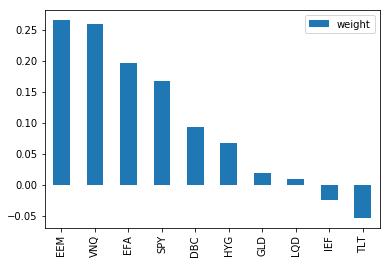

In [4]:
pca = PCA(n_components=1)  # initialize PCA model
pca.fit_transform(returns)  # fit/transform the PCA model to the returns data
components = pca.components_[
    0
]  # select the first component (redundent in this case as we are applying PCA with 1 component)
components_scaled = components / np.sum(
    components
)  # normalize the weights so the sum to zero
pca_portfolio = pd.DataFrame(
    data=components_scaled, columns=["weight"], index=tickers
).sort_values(
    by="weight", ascending=False
)  # store output in dataframe\
pca_portfolio.plot(kind="bar")  # display the normalized factor loadings

# Construct Portfolios
Create two portfolios based on the components of the PCA model: offense and defense. 

In [5]:
offense_portfolio = pca_portfolio[
    pca_portfolio > 0
].dropna()  # select assets with positive exposure
offense_portfolio.weight = offense_portfolio.weight / sum(
    offense_portfolio.weight
)  # reweight for long-only offense portfolio

defense_portfolio = abs(
    pca_portfolio[pca_portfolio < 0].dropna()
)  # take absolute value so weights are positive
defense_portfolio.weight = defense_portfolio.weight / sum(
    defense_portfolio.weight
)  # reweight for long-only defense portfolio

offense_tickers = list(
    offense_portfolio.index
)  # store offense tickers as list. used later to select from price/returns dataframe
defense_tickers = list(
    defense_portfolio.index
)  # store defense tickers as list. used later to select from price/returns dataframe

print("Offense Portfolio Weights")
display(offense_portfolio)

print("Defense Portfolio Weights")
display(defense_portfolio)

Offense Portfolio Weights


,weight
EEM,0.246325
VNQ,0.240192
EFA,0.182723
SPY,0.155726
DBC,0.086332
HYG,0.062644
GLD,0.018064
LQD,0.007995


Defense Portfolio Weights


,weight
IEF,0.3185
TLT,0.6815


## Calculate moving average signal and portfolio positioning

In [6]:
# create dataframes of the prices for the offense and defense portfolios
offense_prices = prices.loc[:, offense_tickers].dot(offense_portfolio)
defense_prices = prices.loc[:, defense_tickers].dot(defense_portfolio)

signal_length = 252
offense_sma = offense_prices.rolling(signal_length).mean()  # calculate moving average
offense_sma = (
    offense_sma.dropna()
)  # drop the first signal_length terms from series as they are NA
signal = (
    offense_prices[signal_length - 1 :] >= offense_sma
)  # 1 if offense portfolio is above its moving average, 0 otherwise
signal = signal.astype(int)  # convert from boolean to integer
# update offense and defense prices to match length of signal, otherwise they will not match up
offense_prices = offense_prices[signal_length - 1 :]
defense_prices = defense_prices[signal_length - 1 :]
strategy_df = pd.concat([offense_prices, defense_prices, offense_sma, signal], axis=1)
strategy_df.columns = ["off_price", "def_price", "off_sma", "signal"]

## Plot our data so far
We can see below that the moving-average signal would have dodged some of the pain in 2009. It also would have created some whipsaws in 2011 and 2015, which is the risk of this strategy.

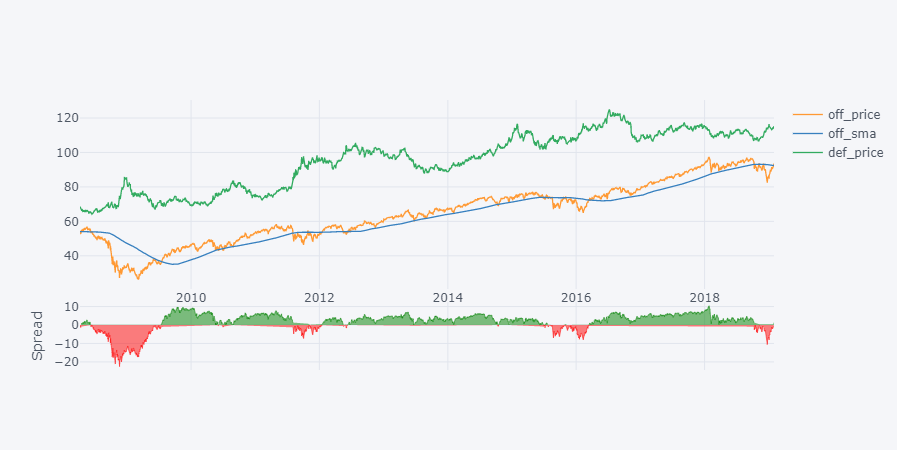

In [8]:
strategy_df[["off_price", "off_sma", "def_price"]].iplot(kind="spread")

# Backtest
For a simple strategy like this we can us the `bt` package to run a backtest.

Stat                 Offense     Defense     Eigen SMA
-------------------  ----------  ----------  -----------
Start                2008-09-24  2008-09-24  2008-09-24
End                  2019-01-31  2019-01-31  2019-01-31
Risk-free rate       0.00%       0.00%       0.00%

Total Return         73.97%      70.35%      100.88%
Daily Sharpe         0.35        0.49        0.56
Daily Sortino        0.55        0.83        0.90
CAGR                 5.49%       5.28%       6.97%
Max Drawdown         -46.61%     -21.71%     -21.87%
Calmar Ratio         0.12        0.24        0.32

MTD                  8.89%       0.47%       -0.38%
3m                   4.75%       7.10%       -5.17%
6m                   -1.87%      3.66%       -9.83%
YTD                  8.89%       0.47%       -0.38%
1Y                   -4.28%      2.69%       -10.77%
3Y (ann.)            10.59%      1.08%       6.20%
5Y (ann.)            5.28%       4.33%       7.59%
10Y (ann.)           10.56%      4.25%       6.00%
Si

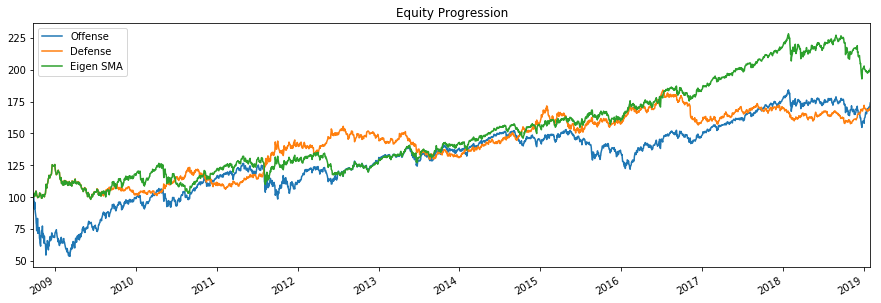

In [7]:
portfolio_prices = pd.concat([offense_prices, defense_prices], axis=1)
portfolio_prices.columns = ["offense", "defense"]

sma = (
    offense_prices.rolling(window=252, center=False).mean().shift(1)
)  # create trend signal
trend = sma.copy()
trend[offense_prices > sma] = True
trend[offense_prices <= sma] = False
trend[sma.isnull()] = False
trend["defense"] = True - trend
trend.columns = ["offense", "defense"]

offense_weights = pd.Series(
    offense_portfolio.values.flatten(), index=offense_portfolio.index
)
defense_weights = pd.Series(
    defense_portfolio.values.flatten(), index=defense_portfolio.index
)

weighSpecifiedAlgo = bt.algos.WeighSpecified(**offense_weights)
s = bt.Strategy(
    "Offense",
    [
        bt.algos.RunMonthly(),
        bt.algos.SelectAll(),
        weighSpecifiedAlgo,
        bt.algos.Rebalance(),
    ],
)

offense_bt = bt.Backtest(s, prices.loc["2008-09-25":, :], progress_bar=False)

weighSpecifiedAlgo = bt.algos.WeighSpecified(**defense_weights)
s2 = bt.Strategy(
    "Defense",
    [
        bt.algos.RunMonthly(),
        bt.algos.SelectAll(),
        weighSpecifiedAlgo,
        bt.algos.Rebalance(),
    ],
)

defense_bt = bt.Backtest(s2, prices, progress_bar=False)


s3 = bt.Strategy(
    "Eigen SMA",
    [
        bt.algos.RunMonthly(),
        bt.algos.SelectWhere(trend),
        bt.algos.WeighEqually(),
        bt.algos.Rebalance(),
    ],
)

sma_bt = bt.Backtest(s3, portfolio_prices, progress_bar=False)
res = bt.run(offense_bt, defense_bt, sma_bt)
res.plot()
res.display()

# Looks good...but...
We can't do this. We used the entire dataset to construct the portfolios then tested those portfolios on the same dataset. This is a major violation of look ahead bias. Stated simply, had we constructed these portfolios in real time we would not have known what the future data would be and thus what the weightings would be. We need to instead "walk" the model forward and incorporate new data as it arrives. This is done in the cells below.

In [10]:
recalc_dates = returns.resample("BQ", level="date").mean().index.values[:-1]

date_counter = 1
models = pd.Series(index=recalc_dates)
components = pd.DataFrame()
offense_portfolios = pd.DataFrame()
defense_portfolios = pd.DataFrame()
offense_prices = pd.DataFrame()
defense_prices = pd.DataFrame()
for date in recalc_dates[:-2]:
    #     X_train = returns.loc[date:recalc_dates[date_counter],:]
    X_train = returns.loc[: recalc_dates[date_counter], :]
    #     y_train = prices.loc[recalc_dates[date_counter]:recalc_dates[date_counter+1]-pd.Timedelta('1 days'),:]
    y_train = prices.loc[
        recalc_dates[date_counter] : recalc_dates[date_counter + 1]
        - pd.Timedelta("1 days"),
        :,
    ]
    date_counter += 1
    model = PCA(n_components=1)
    model.fit_transform(X_train)
    models.loc[date] = model

    components_scaled = model.components_[0] / np.sum(model.components_[0])
    component_series = pd.Series(components_scaled, index=tickers)
    component_series.name = date
    components = pd.concat([components, component_series], axis=1, sort=True)

    pca_portfolio = pd.Series(
        data=components_scaled, name=date, index=tickers
    ).sort_values(ascending=False)

    offense_portfolio = pca_portfolio[
        pca_portfolio > 0
    ].dropna()  # select assets with positive exposure
    offense_portfolio = offense_portfolio / sum(
        offense_portfolio
    )  # reweight for long-only offense portfolio
    offense_portfolios = pd.concat(
        [offense_portfolios, offense_portfolio], axis=1, sort=True
    )

    defense_portfolio = abs(
        pca_portfolio[pca_portfolio < 0].dropna()
    )  # need to use abs so weights are positive
    defense_portfolio = defense_portfolio / sum(
        defense_portfolio
    )  # reweight for long-only offense portfolio
    defense_portfolios = pd.concat(
        [defense_portfolios, defense_portfolio], axis=1, sort=True
    )

    offense_tickers = list(offense_portfolio.index)
    defense_tickers = list(defense_portfolio.index)

    offense_price = y_train.loc[:, offense_tickers].dot(offense_portfolio)
    offense_prices = pd.concat([offense_prices, offense_price], axis=0, sort=True)
    defense_price = y_train.loc[:, defense_tickers].dot(defense_portfolio)
    defense_prices = pd.concat([defense_prices, defense_price], axis=0, sort=True)

#     print("Training on the {} records, through {}"\
#           .format(len(X_train),y_train.index.get_level_values('date').max()))

offense_portfolios = pd.DataFrame(offense_portfolios.transpose())
defense_portfolios = pd.DataFrame(defense_portfolios.transpose())

offense_portfolios = offense_portfolios.fillna(value=0)
defense_portfolios = defense_portfolios.fillna(value=0)

eigen_portfolios = offense_portfolios.join(
    defense_portfolios, how="outer", lsuffix="_left", rsuffix="_right"
)
eigen_portfolios = eigen_portfolios.set_index(recalc_dates[:-2])

signal_length = 252
offense_sma = offense_prices.rolling(signal_length).mean()
offense_sma = offense_sma.dropna()
signal = offense_prices[signal_length - 1 :] > offense_sma
signal = signal.astype(int)
signal.columns = ["offense"]
signal["defense"] = 1 - signal

We can see below how the weights in the offense portfolio evolved as the model incorporated more data before settling down to long run values.

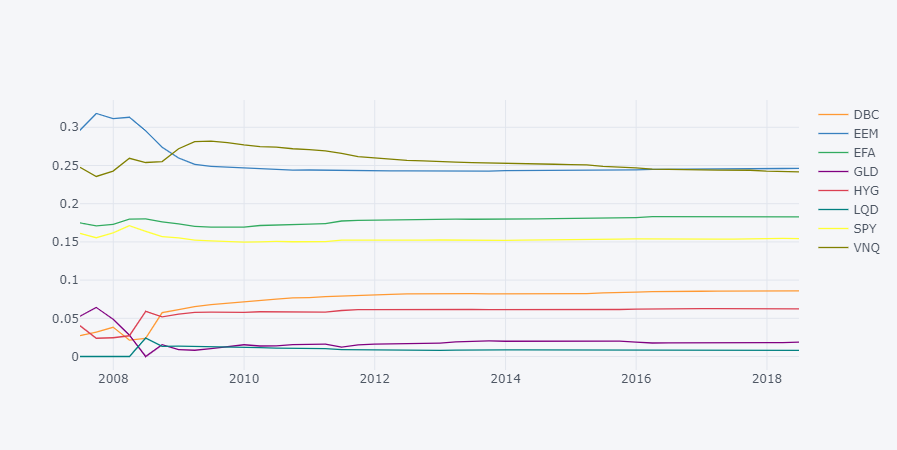

In [11]:
offense_portfolios.iplot()

# Walk-forward backtest

Stat                 Offense     Defense     Eigen SMA Walk
-------------------  ----------  ----------  ----------------
Start                2008-09-25  2008-09-25  2008-09-25
End                  2018-12-28  2018-12-28  2018-12-28
Risk-free rate       0.00%       0.00%       0.00%

Total Return         78.37%      72.40%      114.96%
Daily Sharpe         0.38        0.50        0.62
Daily Sortino        0.58        0.86        1.00
CAGR                 5.80%       5.45%       7.75%
Max Drawdown         -45.85%     -20.91%     -20.91%
Calmar Ratio         0.13        0.26        0.37

MTD                  -7.16%      4.56%       0.76%
3m                   -10.75%     3.98%       -3.46%
6m                   -7.15%      1.25%       0.43%
YTD                  -7.59%      -1.28%      -0.05%
1Y                   -7.67%      -1.12%      -0.13%
3Y (ann.)            5.86%       1.95%       10.09%
5Y (ann.)            4.95%       5.11%       6.97%
10Y (ann.)           10.03%      3.08%       

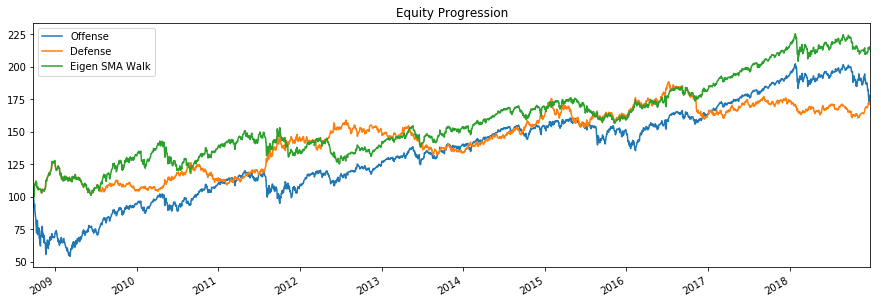

In [12]:
bt_prices = pd.concat([offense_prices, defense_prices], axis=1)
bt_prices.columns = ["offense", "defense"]
bt_prices = bt_prices.loc[signal.index[0] :, :]

s = bt.Strategy(
    "Offense",
    [
        bt.algos.RunDaily(),
        bt.algos.SelectAll(),
        bt.algos.WeighEqually(),
        bt.algos.Rebalance(),
    ],
)

offense_walk = bt.Backtest(s, data=pd.DataFrame(bt_prices.offense), progress_bar=False)


s2 = bt.Strategy(
    "Defense",
    [
        bt.algos.RunDaily(),
        bt.algos.SelectAll(),
        bt.algos.WeighEqually(),
        bt.algos.Rebalance(),
    ],
)

defense_walk = bt.Backtest(s2, pd.DataFrame(bt_prices.defense), progress_bar=False)

s3 = bt.Strategy(
    "Eigen SMA Walk",
    [
        bt.algos.RunDaily(),
        bt.algos.SelectWhere(trend),
        bt.algos.WeighEqually(),
        bt.algos.Rebalance(),
    ],
)

eigen_walk = bt.Backtest(s3, bt_prices, progress_bar=False)
res = bt.run(offense_walk, defense_walk, eigen_walk)
res.plot()
res.display()

# Compare look-ahead versus walk-forward model

In [13]:
res = bt.run(sma_bt, eigen_walk)
res.display()

Stat                 Eigen SMA    Eigen SMA Walk
-------------------  -----------  ----------------
Start                2008-09-25   2008-09-25
End                  2018-12-28   2018-12-28
Risk-free rate       0.00%        0.00%

Total Return         101.24%      114.96%
Daily Sharpe         0.56         0.62
Daily Sortino        0.90         1.00
CAGR                 7.06%        7.75%
Max Drawdown         -21.87%      -20.91%
Calmar Ratio         0.32         0.37

MTD                  -7.75%       0.76%
3m                   -10.86%      -3.46%
6m                   -7.22%       0.43%
YTD                  -7.79%       -0.05%
1Y                   -7.85%       -0.13%
3Y (ann.)            7.40%        10.09%
5Y (ann.)            7.10%        6.97%
10Y (ann.)           4.88%        5.38%
Since Incep. (ann.)  7.06%        7.75%

Daily Sharpe         0.56         0.62
Daily Sortino        0.90         1.00
Daily Mean (ann.)    7.79%        8.39%
Daily Vol (ann.)     13.86%       13.59%
Dai

# Conclusion
The performance of the strategy actually went up. We can see in the plot of the security weights below that this was due to the walk-forward model switching faster and more frequently than the look-ahead model. In reality, all these transactions have explicit and implicit costs not captured in this test. My suspision is that the results would be much closer if these were included. My goal was simply to examine how a strategy using eigen-portfolios could work--not to prove some point about look-ahead bias.

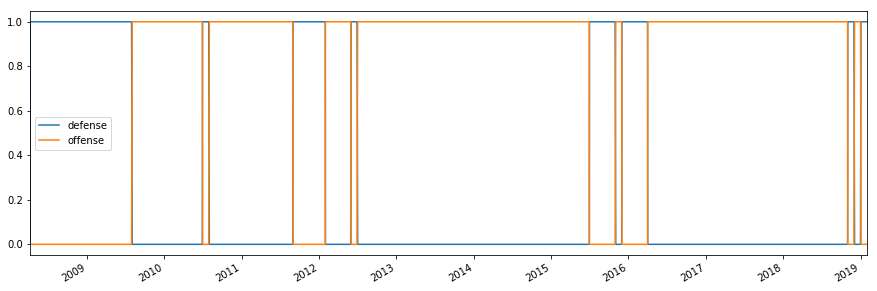

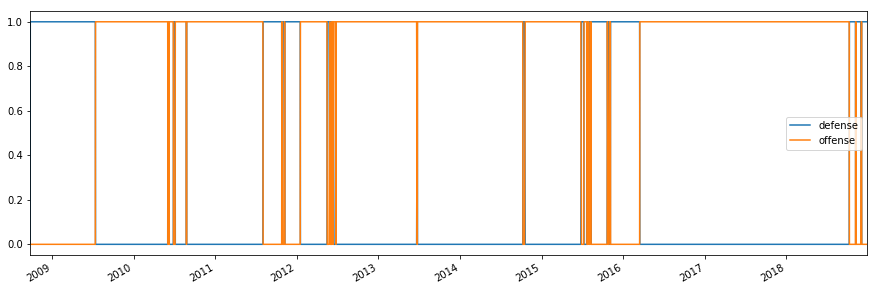

In [13]:
res.plot_security_weights(backtest='Eigen SMA')
res.plot_security_weights(backtest='Eigen SMA Walk')